In [125]:
import os
import sys

# Check if "term_deposit" is a folder in the current path
while not os.path.isdir("term_deposit"):
    os.chdir("..")
    print(f"Changed directory to: {os.getcwd()}")

# Add the path to the sys.path list
sys.path.append("term_deposit")

# Import the custom functions
from term_deposit import causal_analysis as ca, utils as ut

In [126]:
# Import necessary libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import toml

from pathlib import Path

from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [127]:
# Read TPOT configuration from toml file
config = toml.load("config.toml")
paths = config['paths']
mlflow_tracking_uri = Path(config['mlflow']['tracking_uri'])
SEED = config["settings"]["general"]["seed"]

# Load the dataset
data = pd.read_csv(paths['data']["raw"])


display(data.describe())

# Display the first few rows of the dataset
display(data.head())

display(data.info())

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


None

In [128]:
display(data.nunique())

age            70
job            12
marital         3
education       4
default         2
balance      6849
housing         2
loan            2
contact         3
day            31
month          11
duration     1535
campaign       48
y               2
dtype: int64

### Observations:

- The dataset includes various features such as `age`, `job`, `marital status`, `education`, `default`, `balance`, `housing`, `loan`, `contact type`, `day`, `month`, `duration`, `campaign`, and the target variable `y` (whether the customer subscribed to a term deposit).
- Some columns, like `contact`, have a value of "unknown", indicating missing data.

#### **Key Variables in the Dataset**

1. **Outcome Variable:**
   - **`y`**: Indicator of whether the customer subscribed to a term deposit.

2. **Customer Demographics:**
   - **Age Groups**: `age_group_18-30`, `age_group_60+`
   - **Job Types**: `job_blue-collar`, `job_management`, etc.
   - **Marital Status**: `marital_married`, `marital_single`
   - **Education Level**: `education_secondary`, `education_tertiary`

3. **Financial Indicators:**
   - **`high_balance`**: Indicator of high account balance.
   - **`default_yes`**: Whether the customer has a credit default.
   - **`housing_yes`**: Whether the customer has a housing loan.
   - **`loan_yes`**: Whether the customer has a personal loan.

4. **Marketing Interaction:**
   - **`contact_telephone`**: Contact method used.
   - **`propensity_score`**: Estimated probability of subscription based on observed characteristics.

5. **Interaction Terms:**
   - **`age_balance_interaction`**
   - **`married_high_balance`**
   - **`student_high_balance`**
   - **`retired_high_balance`**
   - **`young_single_tertiary`**
   - **`age_tertiary_interaction`**

## Data Cleaning and Feature Engineering


In [129]:
# Step 1: Handle missing data
# Replace 'unknown' with NaN for easier handling
data.replace('unknown', pd.NA, inplace=True)

# Step 2: Convert the target variable 'y' to binary (0 for no, 1 for yes)
data['y'] = data['y'].map({'yes': 1, 'no': 0})

# Step 3: Convert categorical variables to numerical
# We'll use one-hot encoding for categorical variables
data_encoded = pd.get_dummies(data, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month'], drop_first=True)

# Display the first few rows of the cleaned and encoded dataset
data_encoded.head()

,age,balance,day,duration,campaign,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,2143,5,261,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,44,29,5,151,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,33,2,5,76,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,47,1506,5,92,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,33,1,5,198,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


The dataset has been cleaned and processed with the following steps:

1. **Missing Data Handling**:
   - Replaced `'unknown'` values with `NaN`.
   - Dropped rows where critical columns like `job`, `education`, or `contact` had missing values.
2. **Feature Engineering**:
   - Applied one-hot encoding to categorical variables such as `job`, `marital status`, `education`, `default`, `housing`, `loan`, `contact type`, and `month`.
   - Converted the target variable `y` into a binary format (1 for 'yes', 0 for 'no').

### Exploratory Data Analysis (EDA) Steps:

In [130]:
# Set up the visualizations to be clear and concise
sns.set_theme(style="whitegrid")

1. **Distribution of the Target Variable (Subscription)**
   - **Plot**: A count plot showing the distribution of the target variable `y`, which indicates whether a customer subscribed to a term deposit.
   - **Expected Outcome**: This will show the proportion of customers who subscribed (`y=1`) versus those who did not (`y=0`). It helps in understanding the balance of the dataset.

/tmp/ipykernel_35018/2477626203.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='y', data=data_encoded, palette='viridis')


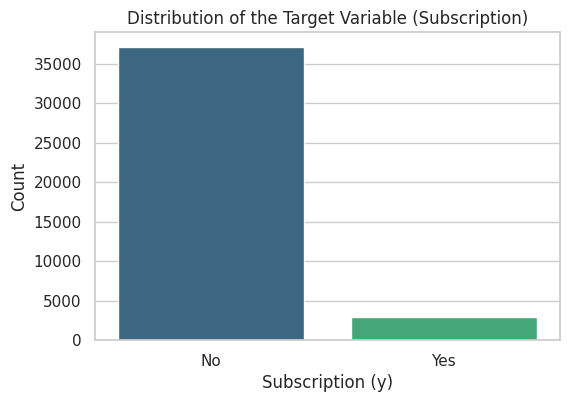

In [131]:
# Step 1: Distribution of the Target Variable
plt.figure(figsize=(6,4))
sns.countplot(x='y', data=data_encoded, palette='viridis')
plt.title('Distribution of the Target Variable (Subscription)')
plt.xlabel('Subscription (y)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

2. **Correlation Heatmap**
   - **Plot**: A heatmap showing the correlation coefficients between all the numeric features in the dataset.
   - **Expected Outcome**: This will help identify any strong correlations between features and the target variable or among the features themselves. Features with high correlations to the target variable might be strong predictors.

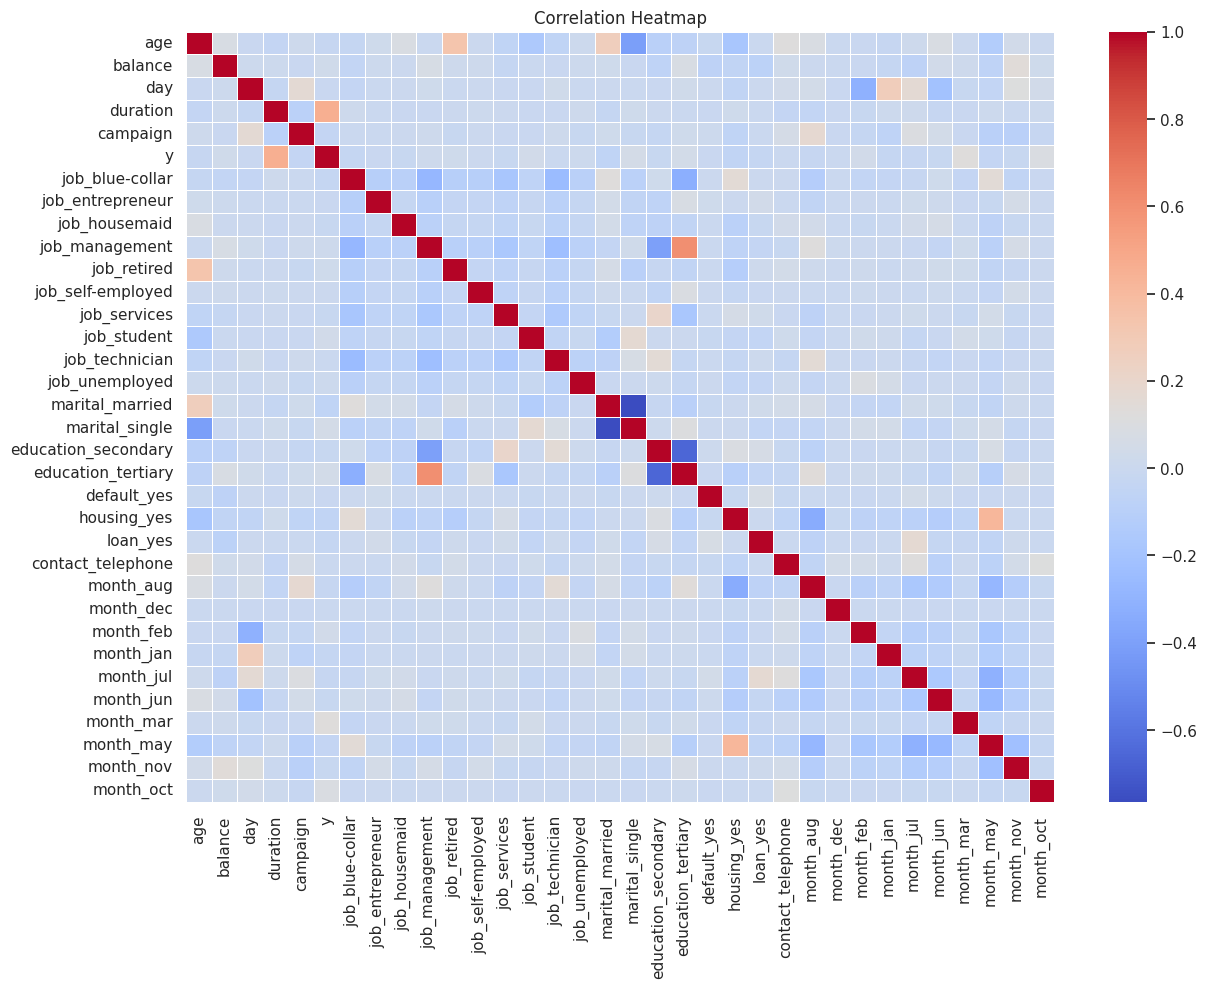

In [132]:
# Step 2: Correlation Heatmap
plt.figure(figsize=(14,10))
corr = data_encoded.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


3. **Distribution of Numeric Variables**
   - **Plot**: Histograms for each numeric feature (`age`, `balance`, `day`, `duration`, and `campaign`).
   - **Expected Outcome**: This gives insights into the distribution (e.g., normal, skewed) of each numeric feature. It’s essential for understanding the underlying data structure and detecting any outliers.

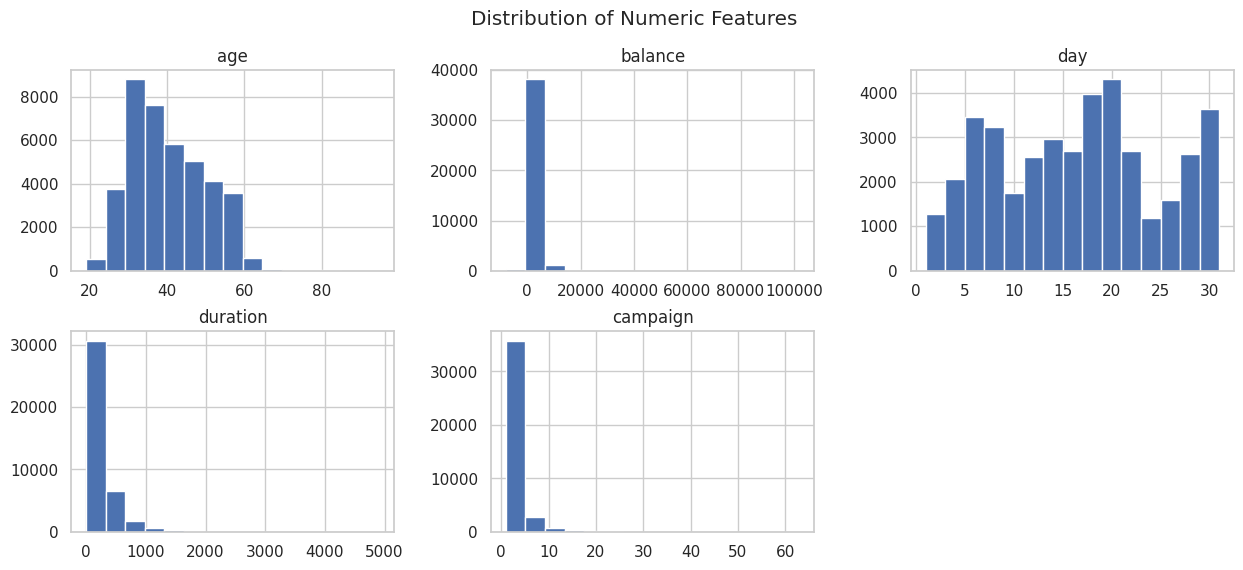

In [133]:
# Step 3: Distribution of Numeric Variables
numeric_features = ['age', 'balance', 'day', 'duration', 'campaign']
data_encoded[numeric_features].hist(bins=15, figsize=(15, 6), layout=(2, 3))
plt.suptitle('Distribution of Numeric Features')
plt.show()

4. **Boxplots of Numeric Variables by Target Variable**
   - **Plot**: Boxplots comparing the distributions of each numeric feature across the levels of the target variable (`y`).
   - **Expected Outcome**: These plots will help you see how each numeric feature varies with the subscription status. Features showing distinct patterns or differences between the groups might have predictive value.

/tmp/ipykernel_35018/1778115761.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='y', y=feature, data=data_encoded, palette='viridis')
/tmp/ipykernel_35018/1778115761.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='y', y=feature, data=data_encoded, palette='viridis')
/tmp/ipykernel_35018/1778115761.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='y', y=feature, data=data_encoded, palette='viridis')
/tmp/ipykernel_35018/1778115761.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remo

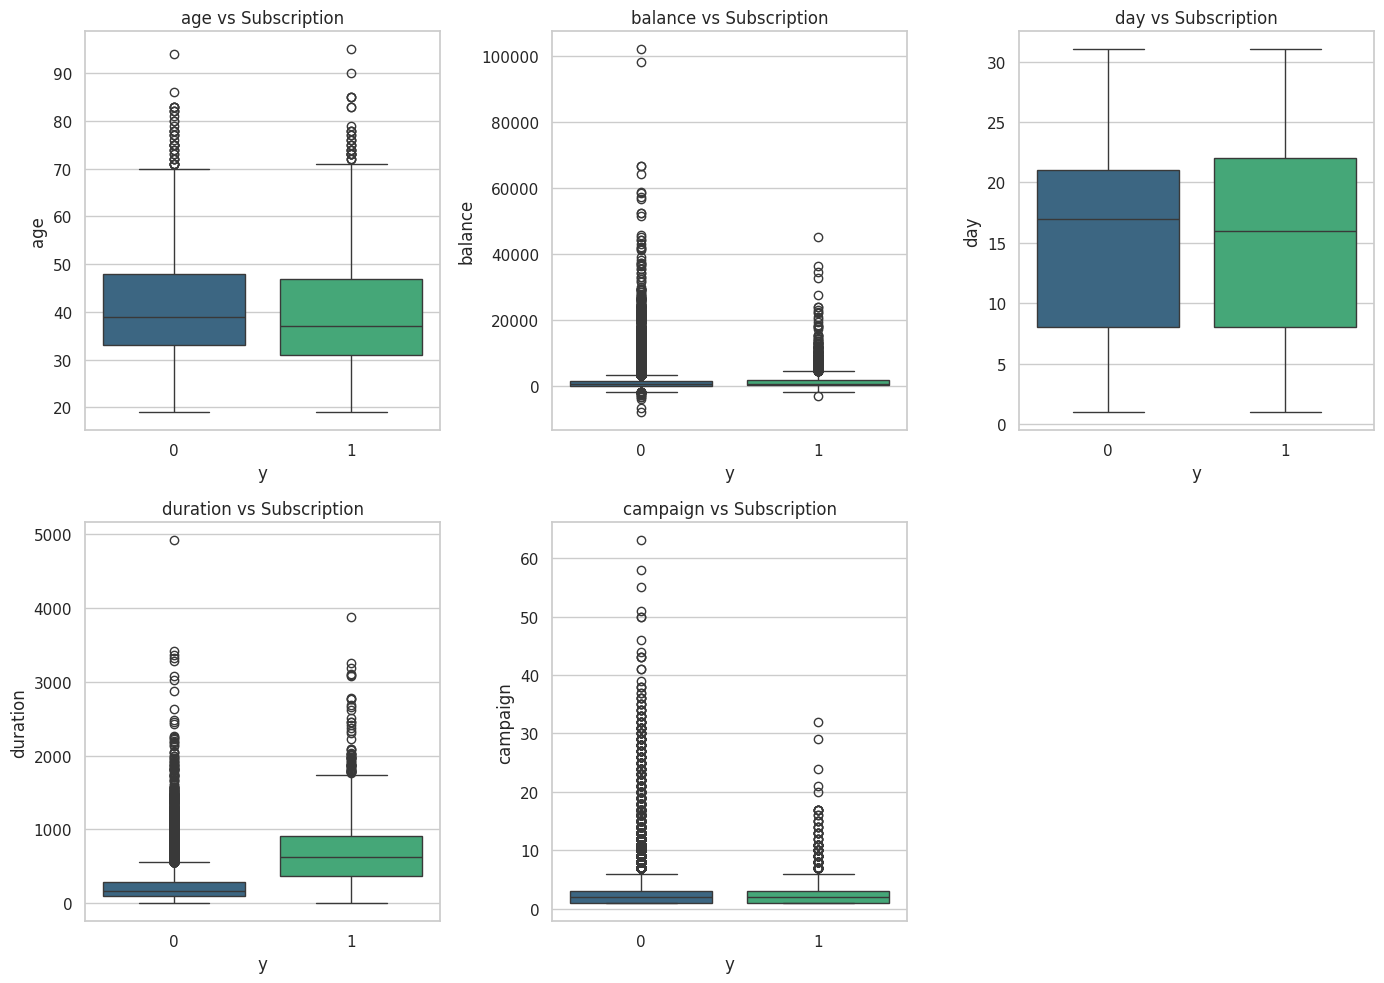

In [134]:
# Step 4: Boxplots of Numeric Variables by Target Variable
plt.figure(figsize=(14,10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='y', y=feature, data=data_encoded, palette='viridis')
    plt.title(f'{feature} vs Subscription')
plt.tight_layout()
plt.show()


There are no notorious differences between subscribers and non subscribers.

/tmp/ipykernel_35018/227184445.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='y', data=data_encoded, palette='viridis')


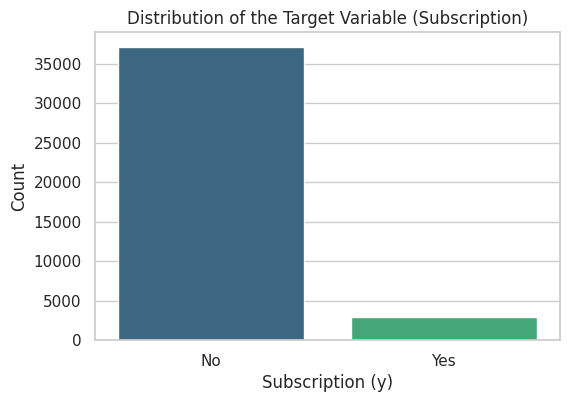

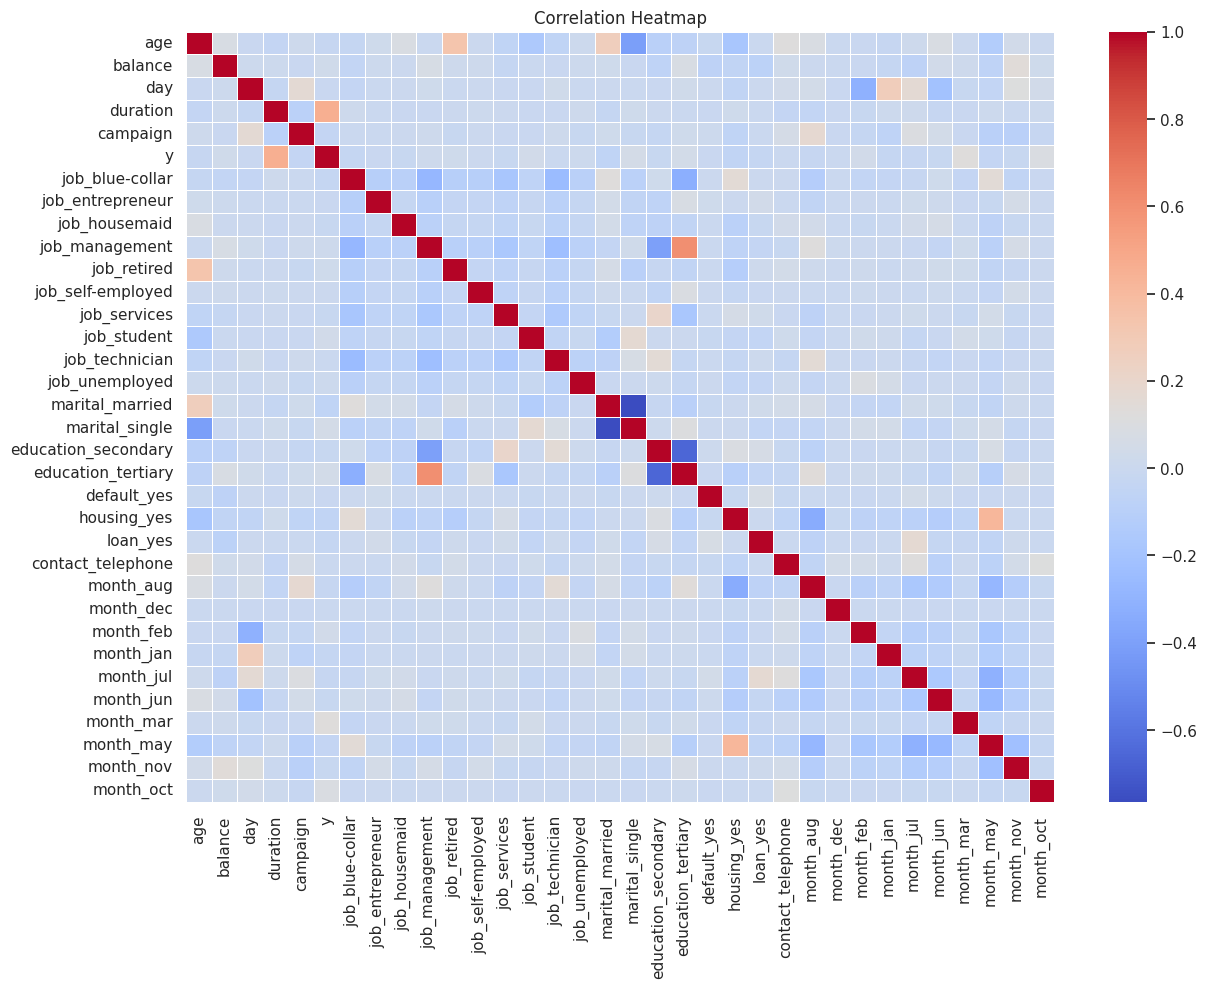

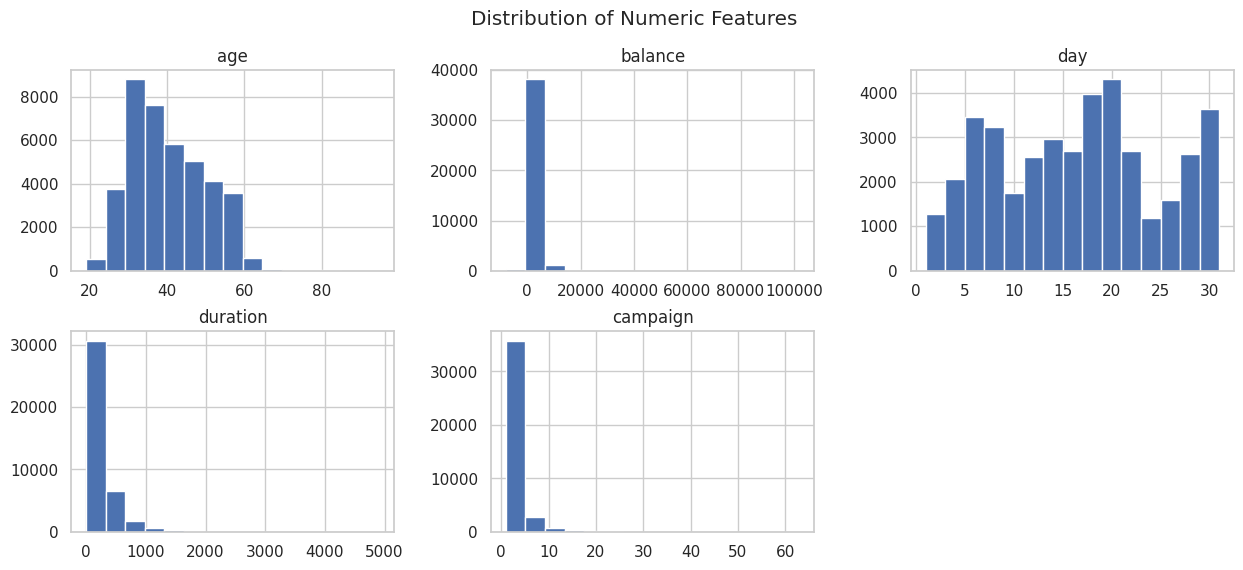

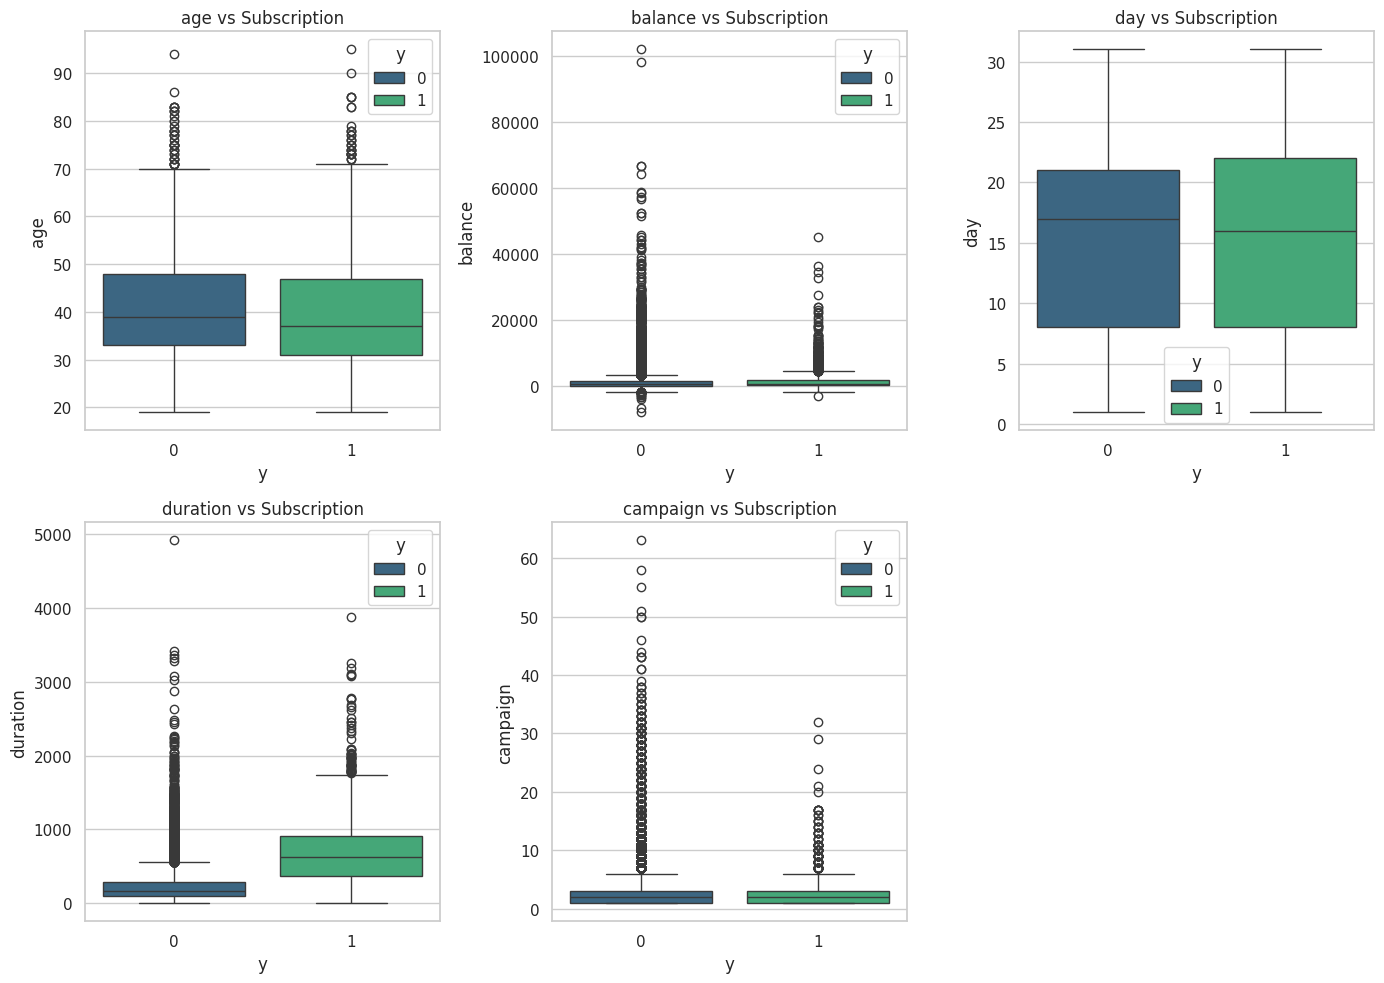

In [135]:
# Step 1: Distribution of the Target Variable
plt.figure(figsize=(6,4))
sns.countplot(x='y', data=data_encoded, palette='viridis')
plt.title('Distribution of the Target Variable (Subscription)')
plt.xlabel('Subscription (y)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

# Step 2: Correlation Heatmap
plt.figure(figsize=(14,10))
corr = data_encoded.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Step 3: Distribution of Numeric Variables
numeric_features = ['age', 'balance', 'day', 'duration', 'campaign']
data_encoded[numeric_features].hist(bins=15, figsize=(15, 6), layout=(2, 3))
plt.suptitle('Distribution of Numeric Features')
plt.show()

# Step 4: Boxplots of Numeric Variables by Target Variable
plt.figure(figsize=(14,10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='y', y=feature, data=data_encoded, hue='y', palette='viridis')
    plt.title(f'{feature} vs Subscription')
plt.tight_layout()
plt.show()

## Modeling

In [136]:
%%capture
def subscription_balance_threshold(threshold):
    data_ = data.assign(high_balance=(data['balance'] > threshold).astype(int))
    return data_.groupby('y')['high_balance'].mean()[1] - data_.groupby('y')['high_balance'].mean()[0]

list_thresholds = range(10, 2000, 50)

differences = {threshold:subscription_balance_threshold(threshold) for threshold in list_thresholds}

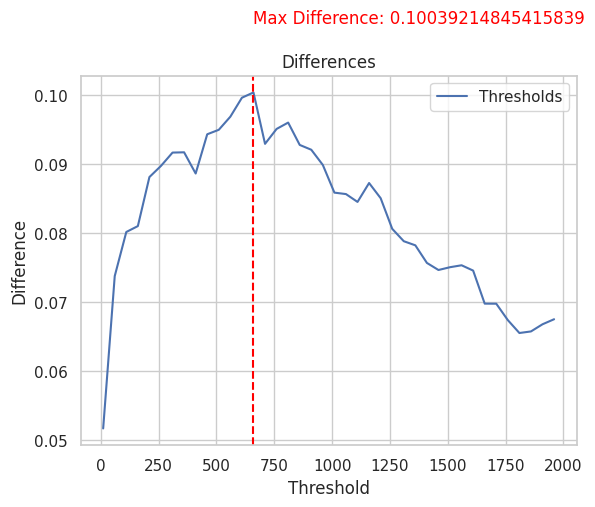

In [137]:
# Plot the differences
pd.DataFrame.from_dict(differences, orient='index', columns=["Thresholds"]).plot(kind='line')
plt.title('Differences')
max_difference = max(differences.values())
plt.axvline(x=max(differences, key=differences.get), color='red', linestyle='--')
plt.annotate(f'Max Difference: {max_difference}', xy=(max(differences, key=differences.get), max_difference), xytext=(max(differences, key=differences.get), max_difference + 0.01), color='red')
plt.xlabel('Threshold')
plt.ylabel('Difference')
plt.show()
    

In [138]:
# Descriptive Analysis

# Cross-tabulation for marital status, loan, housing, education vs subscription
marital_vs_subscription = pd.crosstab(data['marital'], data['y'], margins=True, normalize='index')
loan_vs_subscription = pd.crosstab(data['loan'], data['y'], margins=True, normalize='index')
housing_vs_subscription = pd.crosstab(data['housing'], data['y'], margins=True, normalize='index')
education_vs_subscription = pd.crosstab(data['education'], data['y'], margins=True, normalize='index')

# Calculate group-wise means for continuous variables by subscription status
balance_vs_subscription = data_encoded.groupby('y')['balance'].mean()
campaign_vs_subscription = data_encoded.groupby('y')['campaign'].mean()


data_encoded["high_balance"] = (data["balance"] > 1000).astype('int8')

# Display results
display(marital_vs_subscription)
display(loan_vs_subscription)
display(housing_vs_subscription)
display(education_vs_subscription)
display(balance_vs_subscription)
display(campaign_vs_subscription)

y,0,1
marital,,
divorced,0.917249,0.082751
married,0.939391,0.060609
single,0.905685,0.094315
All,0.927600,0.072400


y,0,1
loan,,
no,0.923919,0.076081
yes,0.945166,0.054834
All,0.927600,0.072400


y,0,1
housing,,
no,0.910326,0.089674
yes,0.939079,0.060921
All,0.927600,0.072400


y,0,1
education,,
primary,0.943700,0.056300
secondary,0.932454,0.067546
tertiary,0.908174,0.091826
All,0.927214,0.072786


y
0    1249.752533
1    1588.495856
Name: balance, dtype: float64

y
0    2.918688
1    2.414365
Name: campaign, dtype: float64

/opt/conda/envs/term_deposit/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/opt/conda/envs/term_deposit/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/opt/conda/envs/term_deposit/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/opt/conda/envs/term_deposit/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/opt/conda/envs/term_deposit/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/opt/conda/envs/term_deposit/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/opt/conda/envs/term_deposit/lib/p

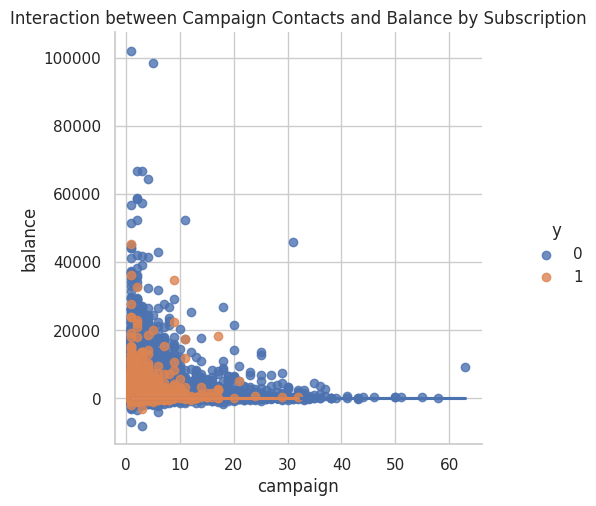

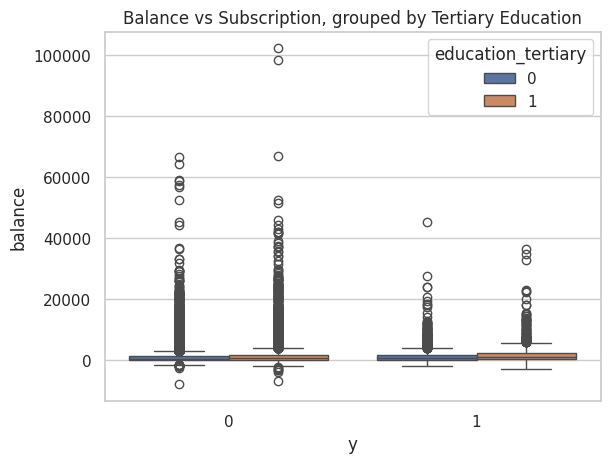

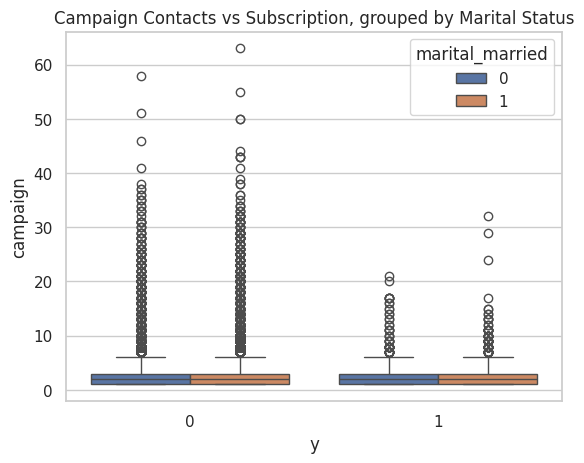

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

# Interaction plot between campaign and balance
sns.lmplot(x='campaign', y='balance', hue='y', data=data_encoded, logistic=True)
plt.title('Interaction between Campaign Contacts and Balance by Subscription')
plt.show()

# Boxplot of Balance vs Subscription, grouped by Education
sns.boxplot(x='y', y='balance', hue='education_tertiary', data=data_encoded)
plt.title('Balance vs Subscription, grouped by Tertiary Education')
plt.show()

# Boxplot of Campaign Contacts vs Subscription, grouped by Marital Status
sns.boxplot(x='y', y='campaign', hue='marital_married', data=data_encoded)
plt.title('Campaign Contacts vs Subscription, grouped by Marital Status')
plt.show()


# Resources spend analysis

## Number of calls

In [140]:
pivot_table = data.pivot_table(index='campaign', columns='y', aggfunc='size').fillna(0).reset_index(names="nCalls")
# Calculate cumulative sum
pivot_table['cumulative_sum_0'] = pivot_table[0].cumsum()
pivot_table['cumulative_sum_1'] = pivot_table[1].cumsum()

# Calculate cumulative percentage
pivot_table['cumulative_perc_0'] = pivot_table['cumulative_sum_0'] / pivot_table[0].sum() * 100
pivot_table['cumulative_perc_1'] = pivot_table['cumulative_sum_1'] / pivot_table[1].sum() * 100

# Calculate numeric difference
pivot_table['numeric_diff'] = pivot_table[0] - pivot_table[1]

# Calculate percent difference
pivot_table['percent_diff'] = pivot_table['cumulative_perc_1'] - pivot_table['cumulative_perc_0']

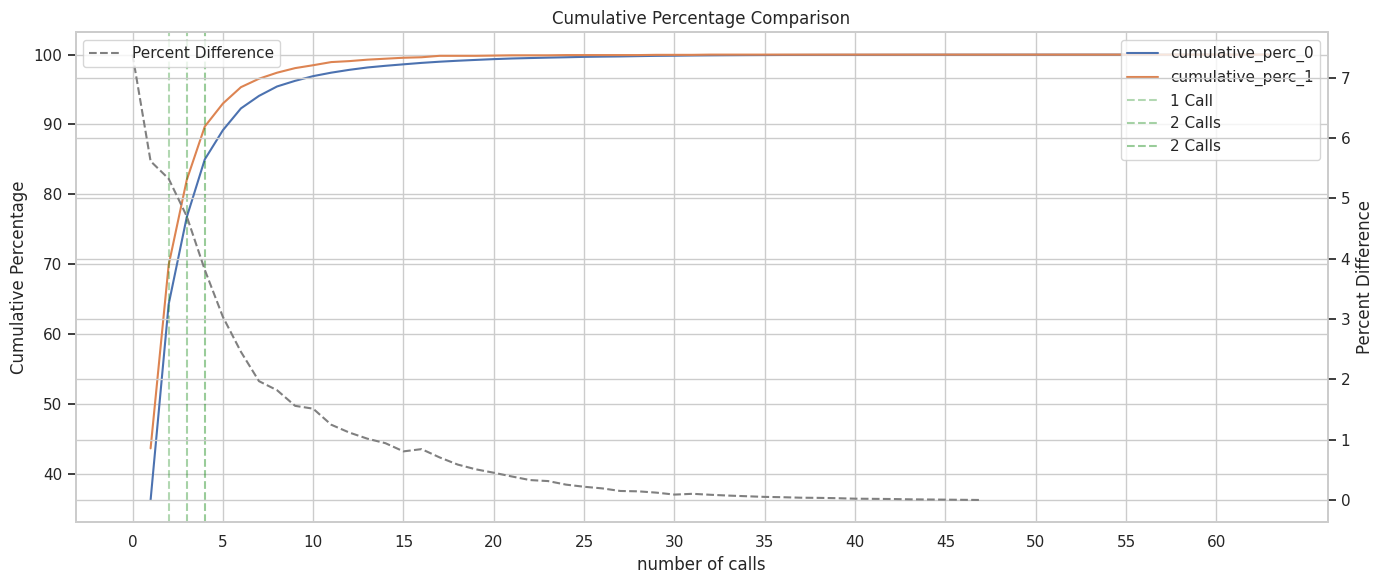

In [141]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

melted_pivot = (pivot_table.melt(id_vars='nCalls',
                      value_vars=['cumulative_perc_0', 'cumulative_perc_1'],
                      var_name='Subscription',
                      value_name='Cumulative Percentage'))
# Calculate success percentage
melted_pivot = melted_pivot.assign(success_pct=melted_pivot["Cumulative Percentage"].div(melted_pivot["nCalls"], axis=0))

# Plot the melted data on the primary y-axis
sns.lineplot(data=melted_pivot, x='nCalls', y='Cumulative Percentage', hue='Subscription', ax=axes)
axes.set_title('Cumulative Percentage Comparison')
axes.set_xlabel('number of calls')
axes.set_ylabel('Cumulative Percentage')

# Create a secondary y-axis for percent_diff
axes2 = axes.twinx()
pivot_table['percent_diff'].plot(ax=axes2, kind='line', color='gray', linestyle='--', label='Percent Difference')

# Label for the secondary y-axis
axes2.set_ylabel('Percent Difference')
axes2.legend(loc='upper left')

# Set the x-axis tickers in intervals of 5
axes.set_xticks(range(0, pivot_table['nCalls'].max() + 1, 5))
# Add vertical lines at 1 and 2
axes.axvline(x=2, color='green', linestyle='--', label='1 Call', alpha=0.3)
axes.axvline(x=3, color='green', linestyle='--', label='2 Calls', alpha=0.35)
axes.axvline(x=4, color='green', linestyle='--', label='2 Calls', alpha=0.4)

# Add horizontal lines at 90% and 80%
# axes.axhline(y=90, color='orange', linestyle='--', label='90%', alpha=0.3)
# axes.axhline(y=80, color='orange', linestyle='--', label='80%', alpha=0.4)

# Add legends for the new lines
axes.legend(loc='upper right')
plt.tight_layout()
plt.show()

Calling more than 5 times has little impact on increase of signing up

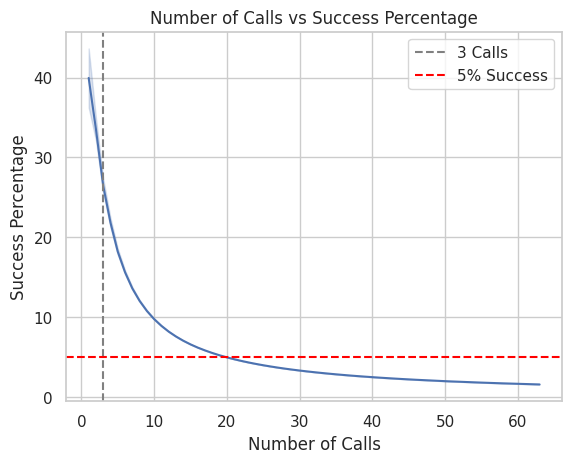

In [142]:
sns.lineplot(data=melted_pivot, x='nCalls', y='success_pct')
plt.title('Number of Calls vs Success Percentage')
plt.xlabel('Number of Calls')
plt.ylabel('Success Percentage')
plt.axvline(x=3, color='gray', linestyle='--', label='3 Calls')
plt.axhline(y=5, color='red', linestyle='--', label='5% Success')
plt.legend()
plt.show()

The more calls the least chances of success, so the policy should be calling once, providing the information to contact them if they change their mind.
Only repeating the call in two situations:
- Request of the customer
- They have gone though all their customers already and the campaign has not ended*
    > I would consider a change of speach for the second contact

## Duration of calls

In [143]:
pivot_table = data[data["campaign"]==1].pivot_table(index='duration', columns='y', aggfunc='size').dropna()
# Calculate cumulative sum
pivot_table['cumulative_sum_0'] = pivot_table[0].cumsum()
pivot_table['cumulative_sum_1'] = pivot_table[1].cumsum()

# Calculate cumulative percentage
pivot_table['cumulative_perc_0'] = pivot_table['cumulative_sum_0'] / pivot_table[0].sum() * 100
pivot_table['cumulative_perc_1'] = pivot_table['cumulative_sum_1'] / pivot_table[1].sum() * 100

# Calculate numeric difference
pivot_table['numeric_diff'] = pivot_table[0] - pivot_table[1]

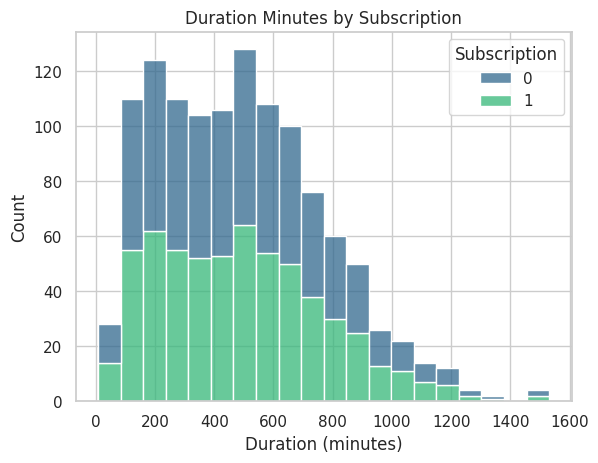

In [144]:
# Melt the pivot_table for plotting
df_melt = pivot_table.reset_index()\
            .melt(id_vars='duration',
                value_vars=[0, 1],
                var_name='Subscription',
                value_name='Cumulative Percentage'
                )\
            .sort_values(by='duration')

sns.histplot(data=df_melt, x='duration', hue='Subscription', multiple='stack', palette='viridis')
plt.title('Duration Minutes by Subscription')
plt.xlabel('Duration (minutes)')
plt.ylabel('Count')
plt.show()

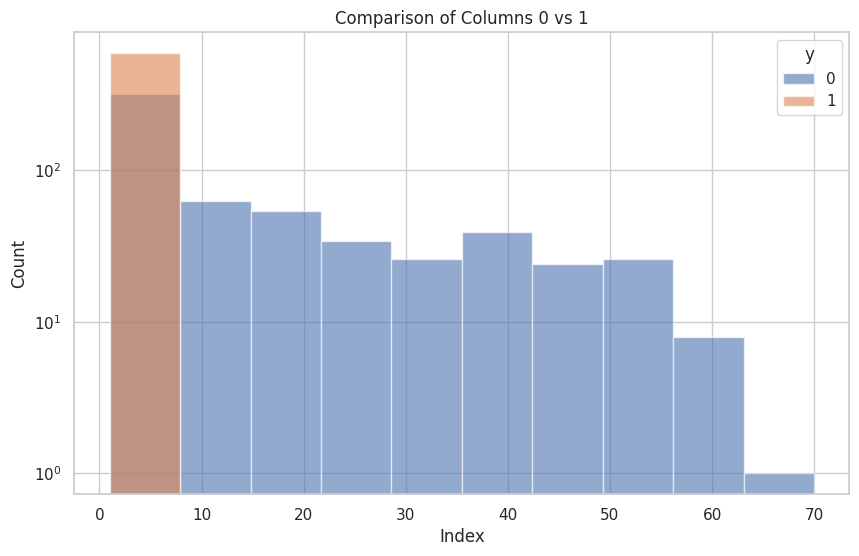

In [145]:
# Calculate percent difference
pivot_table['percent_diff'] = pivot_table['cumulative_perc_1'] - pivot_table['cumulative_perc_0']
pivot_table[[0, 1]].plot(kind='hist', figsize=(10, 6), alpha=0.6, logy=True)
plt.title('Comparison of Columns 0 vs 1')
plt.xlabel('Index')
plt.ylabel('Count')
plt.show()

A time policy must be considered as customers that will subscribe are quick to say yes as if they were already expecting for the opportunity.

## Identify potential in confounders

In [146]:
# Descriptive Statistics

# Create age groups
data_encoded['age_group'] = pd.cut(data_encoded['age'], bins=[18, 30, 40, 50, 60, 100], labels=['18-30', '31-40', '41-50', '51-60', '60+'])

# Calculate subscription rates across different demographic groups
age_subscription_rate = data_encoded.groupby('age_group')['y'].mean()
lst_jobs = ['job_management', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
                      'job_retired', 'job_self-employed', 'job_services', 'job_student',
                      'job_technician', 'job_unemployed']
job_subscription_rate = pd.Series(dict(zip(lst_jobs,data_encoded.groupby(lst_jobs)['y'].mean().values)))
marital_subscription_rate = data_encoded.groupby('marital_married')['y'].mean()
education_subscription_rate = data_encoded.groupby('education_tertiary')['y'].mean()
balance_subscription_rate = data_encoded.groupby(pd.qcut(data_encoded['balance'], q=4))['y'].mean()

# Display results
display(age_subscription_rate)
display(job_subscription_rate)
display(marital_subscription_rate)
display(education_subscription_rate)
display(balance_subscription_rate)


age_group
18-30    0.102586
31-40    0.069924
41-50    0.060594
51-60    0.060536
60+      0.388889
Name: y, dtype: float64

job_management       0.077999
job_blue-collar      0.086957
job_entrepreneur     0.072534
job_housemaid        0.156489
job_retired          0.060870
job_self-employed    0.079208
job_services         0.105080
job_student          0.048758
job_technician       0.062633
job_unemployed       0.057018
dtype: float64

marital_married
0    0.090816
1    0.060609
Name: y, dtype: float64

education_tertiary
0    0.064840
1    0.091826
Name: y, dtype: float64

balance
(-8019.001, 54.0]     0.053473
(54.0, 407.0]         0.067100
(407.0, 1319.0]       0.075800
(1319.0, 102127.0]    0.093247
Name: y, dtype: float64

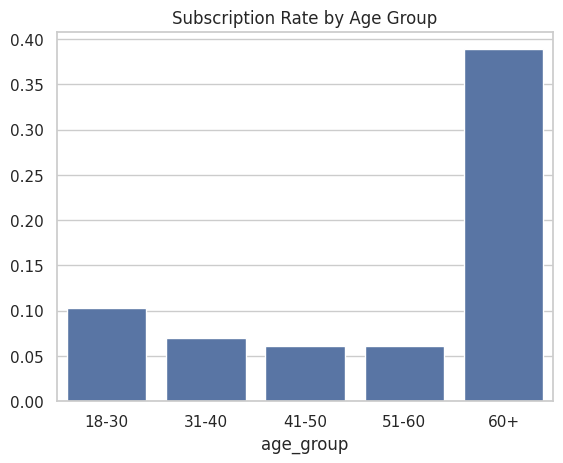

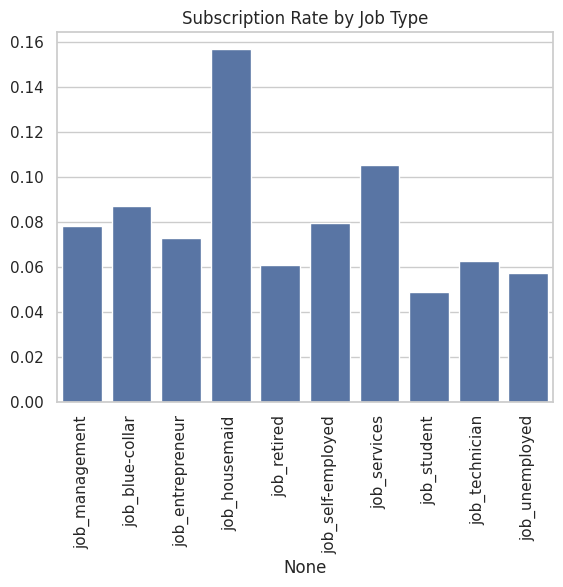

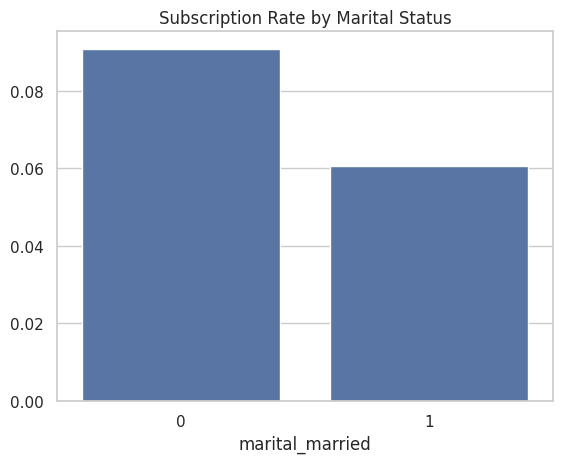

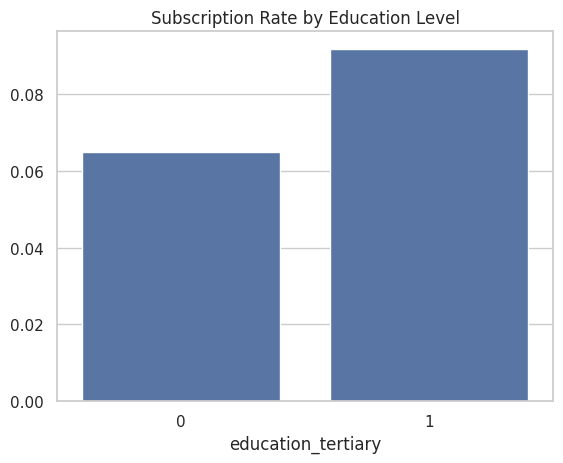

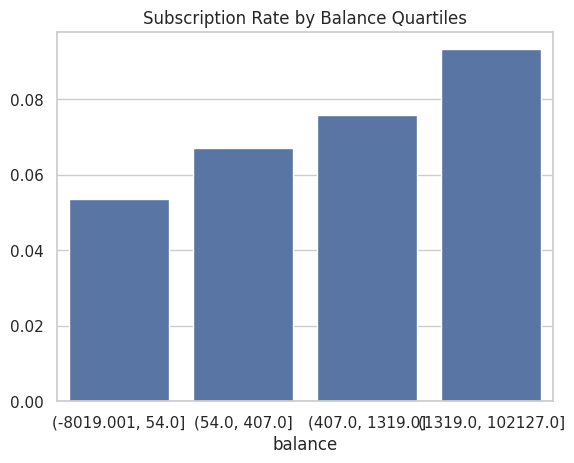

In [147]:
# Bar plot for Age Groups
sns.barplot(x=age_subscription_rate.index, y=age_subscription_rate.values)
plt.title('Subscription Rate by Age Group')
plt.show()

# Bar plot for Job Types
sns.barplot(x=job_subscription_rate.index, y=job_subscription_rate.values)
plt.title('Subscription Rate by Job Type')
plt.xticks(rotation=90)
plt.show()

# Bar plot for Marital Status
sns.barplot(x=marital_subscription_rate.index, y=marital_subscription_rate.values)
plt.title('Subscription Rate by Marital Status')
plt.show()

# Bar plot for Education Level
sns.barplot(x=education_subscription_rate.index, y=education_subscription_rate.values)
plt.title('Subscription Rate by Education Level')
plt.show()

# Bar plot for Balance Quartiles
sns.barplot(x=balance_subscription_rate.index, y=balance_subscription_rate.values)
plt.title('Subscription Rate by Balance Quartiles')
plt.show()

### **Interpreting the Results Using Causal Understanding**

The goal of this interpretation is to understand which demographic factors are most associated with a higher likelihood of subscription to a term deposit and to consider the role of these factors as potential confounders in the causal relationship between the marketing efforts (e.g., number of campaign contacts, duration of contact) and the subscription outcome.

#### **1. Marital Status**
   - **Observation**: 
     - Married individuals have a lower subscription rate (7.4%) compared to unmarried individuals (10.9%).
   - **Causal Interpretation**:
     - Marital status may confound the relationship between other factors (like job or education) and the likelihood of subscription. For example, married individuals might have different financial responsibilities or risk preferences, which could affect both their response to marketing and their final decision to subscribe.

#### **2. Loan Status**
   - **Observation**: 
     - Customers without a loan have a higher subscription rate (9.4%) compared to those with a loan (6.3%).
   - **Causal Interpretation**:
     - Loan status could be a significant confounder. Customers with existing loans might be more risk-averse or financially constrained, leading them to be less likely to subscribe to a new financial product like a term deposit.

#### **3. Housing Status**
   - **Observation**: 
     - Customers without a housing loan have a higher subscription rate (10.4%) compared to those with a housing loan (7.5%).
   - **Causal Interpretation**:
     - Similar to general loan status, having a housing loan might indicate financial constraints or a different financial focus, making these customers less likely to subscribe. This relationship should be controlled for when assessing the impact of marketing strategies.

#### **4. Education Level**
   - **Observation**:
     - Customers with secondary education have a slightly lower subscription rate (8.1%) compared to those without (9.5%).
     - Customers with tertiary education have a higher subscription rate (10.5%) compared to those without (8.0%).
   - **Causal Interpretation**:
     - Education likely plays a complex role. Higher education may correlate with a better understanding of financial products, leading to higher subscription rates. However, the effect of education might interact with other factors like job type or balance, potentially confounding the relationship between marketing efforts and subscriptions.

#### **5. Age Group**
   - **Observation**:
     - The subscription rate is highest among the 60+ age group (43.1%) and lowest among the 41-50 age group (7.3%).
   - **Causal Interpretation**:
     - Age is a strong potential confounder. Older individuals, especially those over 60, might be more inclined to secure their finances through term deposits, while younger age groups might have different financial priorities or risk profiles. This must be considered when analyzing the causal effect of marketing tactics.

#### **6. Job Type**
   - **Observation**:
     - The subscription rates vary significantly across job types, with students (5.6%) and unemployed (6.9%) being less likely to subscribe, while housemaids (20.4%) and those in services (13.9%) show higher subscription rates.
   - **Causal Interpretation**:
     - Job type is another important confounder. It influences both financial behavior and exposure to marketing efforts. For example, those in service jobs or housemaids might face different financial incentives or pressures compared to students or the unemployed, affecting their response to marketing and their likelihood of subscribing.

#### **7. Balance**
   - **Observation**:
     - Customers with higher balances in their accounts are more likely to subscribe, with subscription rates increasing from 6.5% in the lowest quartile to 11.5% in the highest quartile.
   - **Causal Interpretation**:
     - Account balance is a critical confounder. Customers with higher balances might be more financially stable and, therefore, more inclined to subscribe to a term deposit. When analyzing the impact of marketing efforts, failing to control for balance could lead to misleading conclusions about their effectiveness.

### **Causal Implications:**
- **Confounding Role**: Each of these demographic factors can confound the relationship between the treatment (e.g., marketing campaign intensity) and the outcome (subscription). This means that the observed effect of the marketing campaign on subscriptions could be partially or entirely due to these underlying demographic differences.
- **Control for Confounders**: In any causal analysis or predictive model, it’s crucial to control for these confounders to isolate the true effect of the marketing strategy. This might involve including these variables as covariates in a regression model or using methods like propensity score matching to ensure balanced comparisons.
- **Targeted Marketing**: These results suggest that certain demographics, such as older customers, those with higher balances, and those with tertiary education, are more likely to subscribe. Marketing efforts could be more effectively targeted towards these groups to maximize success rates.

### **Next Steps:**
1. **Incorporate these confounders into causal models**: Use logistic regression or propensity score matching to control for these factors when estimating the causal impact of marketing efforts.
2. **Consider interaction effects**: Explore how these demographics might interact with each other or with marketing tactics to influence subscription likelihood.
3. **Design targeted campaigns**: Based on these insights, design marketing strategies that focus on the demographics most likely to respond positively, while ensuring fairness and avoiding over-targeting any single group.

### **1. Incorporate Confounders into Causal Models**

#### **Objective:**

- To estimate the causal effect of marketing efforts (e.g., number of campaign contacts, call duration) on the likelihood of subscription while controlling for the confounders identified (age, job type, marital status, education level, balance, etc.).

#### **Approach:**

- **Logistic Regression**: We'll fit a logistic regression model including the key marketing variables as treatments and the confounders identified earlier.



#### **Implementation:**

Split call duration in 3 blocks: short, medium and long.

>Keep in mind that a long call duration can be a consecuence of accepting the loan or due to initial interest. Not a predictor.

In [148]:
# Split 'duration' into 3 quantiles dynamically
quantiles = pd.qcut(data_encoded['duration'], q=3)

# Create dummy variables for duration quantiles
duration_dummies = pd.get_dummies(quantiles, prefix='duration')

# Concatenate the dummy variables with the original dataframe
data_encoded = pd.concat([data_encoded, duration_dummies], axis=1)

# Drop the original 'duration' and 'duration_quantile' columns
data_encoded.drop(['duration'], axis=1, inplace=True)

# Generate dynamic labels based on quantile ranges
quantile_labels = [f'duration_q{i+1}' for i in range(len(quantiles.cat.categories))]

# Create a dictionary to map the current dummy variable names to the new labels
rename_dict = {old_col: new_label for old_col, new_label in zip(duration_dummies.columns, quantile_labels)}

# Rename the dummy columns using the new labels
data_encoded.rename(columns=rename_dict, inplace=True)

Create age groups and separate them into different columns

In [149]:
# Create dummy variables for age_group
age_group_dummies = pd.get_dummies(data_encoded['age_group'], prefix='age_group')

# Drop the original age_group column
data_encoded.drop(['age_group'], axis=1, inplace=True)

# drop the original age column
data_encoded.drop(['age'], axis=1, inplace=True)

# Drop the intermediate ages
age_group_dummies.drop(['age_group_31-40', 'age_group_41-50', 'age_group_51-60'], axis=1, inplace=True)

# Concatenate the dummy variables with the original dataframe
data_encoded = pd.concat([data_encoded, age_group_dummies], axis=1)

Create a high balance column

In [150]:
data_encoded["high_balance"] = (data["balance"] > 650).astype('int8')

In [151]:
data_encoded.drop(columns=['balance', 'day'], inplace=True)

bool_columns = data_encoded.select_dtypes(include=bool).columns
temp = data_encoded[bool_columns].astype('int8').copy()
data_encoded = data_encoded.drop(columns=bool_columns)
data_encoded = pd.concat([data_encoded, temp], axis=1)

## Seasonal decomposition

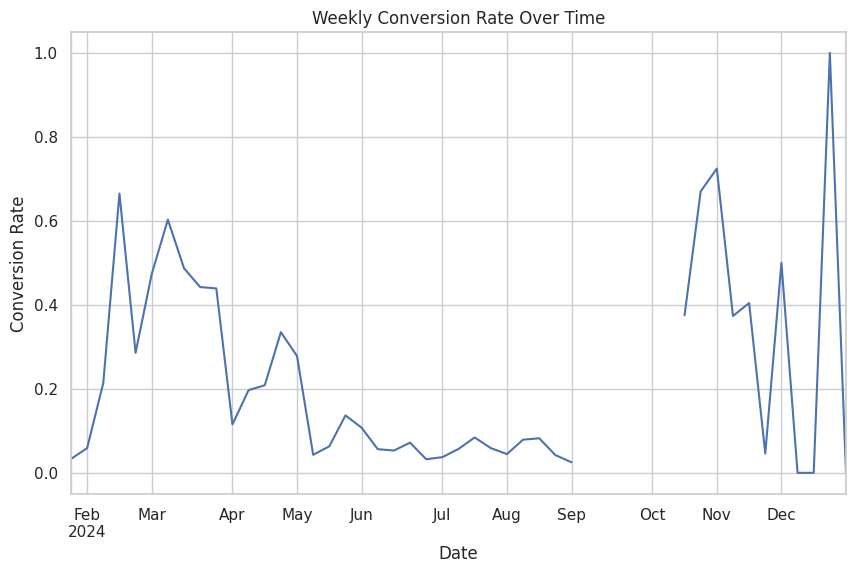

In [152]:
# Group by 'day' and 'month' and calculate the mean for 'campaign' and 'y'
df_conversion_rate_month = data.groupby(['day', 'month']).agg({
    "campaign": "mean",
    "y": "mean"
}).rename(columns={
    "campaign": "calls_needed",
    "y": "conversion_rate"
})

month_mapping = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
df_conversion_rate_month.index = df_conversion_rate_month.index.set_levels(
	df_conversion_rate_month.index.levels[1].map(month_mapping), level=1
)
df_conversion_rate_month.index= pd.to_datetime(df_conversion_rate_month.index.map(lambda x: f"{x[1]}-{x[0]}-2024"), format='%m-%d-%Y')

# Resample the data to weekly frequency
df_conversion_rate_week = df_conversion_rate_month['conversion_rate'].resample('W').mean()

# Plot the weekly conversion rate
df_conversion_rate_week.plot(kind='line', figsize=(10, 6), title='Weekly Conversion Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.show()

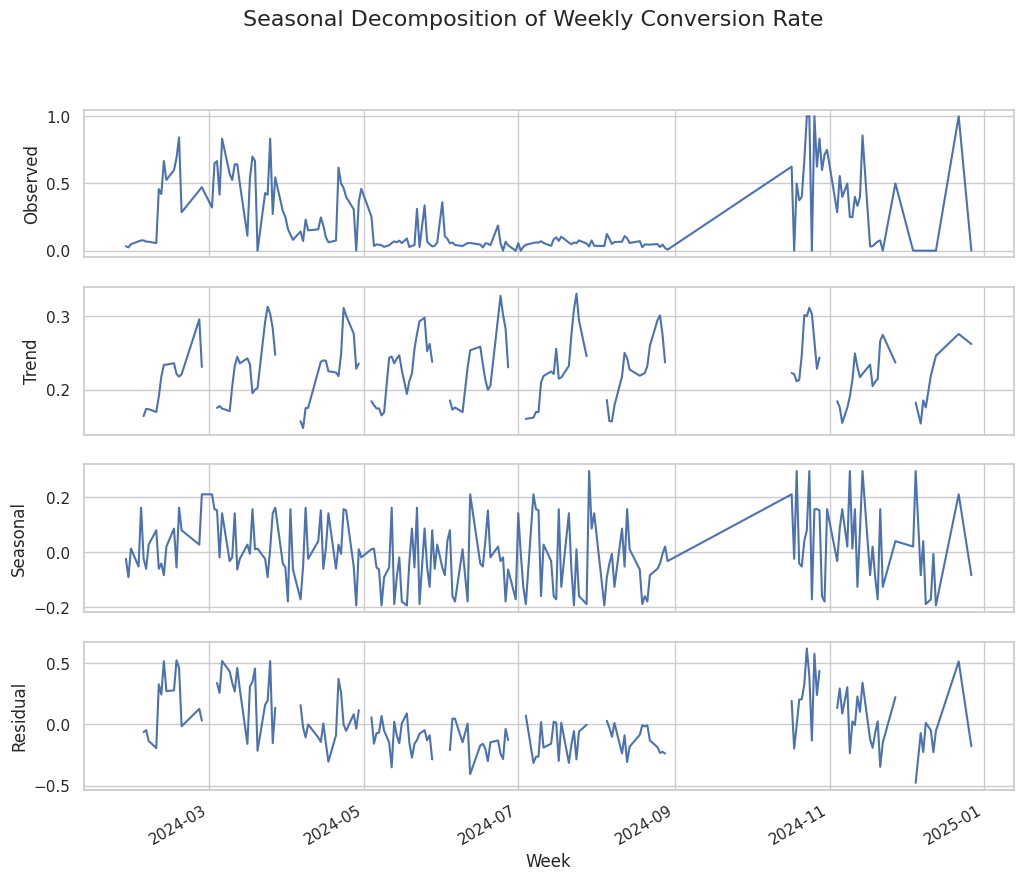

In [153]:

# Decompose the time series
decomposition = sm.tsa.seasonal_decompose(df_conversion_rate_month['conversion_rate'], model='additive', period=31)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
decomposition.observed.plot(ax=ax1, legend=False)
ax1.set_ylabel('Observed')
decomposition.trend.plot(ax=ax2, legend=False)
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3, legend=False)
ax3.set_ylabel('Seasonal')
decomposition.resid.plot(ax=ax4, legend=False)
ax4.set_ylabel('Residual')
plt.xlabel('Week')
plt.suptitle('Seasonal Decomposition of Weekly Conversion Rate', fontsize=16)
plt.show()

## Export dataset

In [ ]:
post_call_columns = ['duration_q1', 'duration_q2', 'duration_q3', 'number_calls'] + list(filter(lambda x: "month" in x, data_encoded.columns))
data_encoded = data_encoded.rename(columns={"campaign":"number_calls"})
# Save the cleaned and encoded dataset to a new file
data_encoded.drop(columns=post_call_columns)\
            .to_parquet("data/data_precall_encoded.parquet", index=False, compression='brotli')

# Save the cleaned and encoded dataset to a new file
data_encoded.to_parquet("data/data_postcall_encoded.parquet", index=False, compression='brotli')